In [1]:
import meta_poisoning_typical as mp
from mlp import *

/home/adam/.conda/envs/jax_py311/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import jax

In [3]:
from importlib import reload
reload(mp)

<module 'meta_poisoning_typical' from '/home/adam/src/sgdensity/meta_poisoning_typical.py'>

# 09-24

In [4]:
cfg = mp.MetaConfig(num_layers=1, weird_xent=True)

In [7]:
seed = 0

if cfg.task == "digits":
    # Load data
    X, Y = mp.load_digits(return_X_y=True)
    X = X / 16.0  # Normalize

    # Split data into "train" and "test" sets
    X_nontest, X_test, Y_nontest, Y_test = mp.train_test_split(
        X, Y, test_size=261, random_state=0, stratify=Y,
    )

    X_train, X_untrain, Y_train, Y_untrain = mp.train_test_split(
        X_nontest, Y_nontest, test_size=768, random_state=0, stratify=Y_nontest,
    )
    
    d_inner = X.shape[1]

    model = MLP(hidden_sizes=(d_inner,) * cfg.num_layers, out_features=10, norm_scale=cfg.norm_scale)
else:
    raise ValueError(f"Unknown task: {cfg.task}")

In [8]:
key = jax.random.key(seed)

params_init = model.init(key, X_nontest)

params_init = Params(params_init)

2024-09-25 18:15:41.683053: W external/xla/xla/service/gpu/nvptx_compiler.cc:836] The NVIDIA driver's CUDA version is 12.2 which is older than the PTX compiler version (12.6.68). Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [9]:
with open('pinit_0924_fast_unx.npy', 'rb') as f:
    params_mp = Params(jnp.load(f, allow_pickle=True), params_init.unravel)

In [10]:
params_init.raveled.shape, params_mp.raveled.shape

((4810,), (4810,))

In [11]:
for layer in params_mp.unraveled['params']:
    print(layer)
    ker_std = jnp.std(params_mp.unraveled['params'][layer]['kernel'])
    print(ker_std)
    bias_std = jnp.std(params_mp.unraveled['params'][layer]['bias'])
    print(bias_std)
    print(ker_std / bias_std)

print("\ninit")
for layer in params_init.unraveled['params']:
    print(layer)
    ker_std = jnp.std(params_init.unraveled['params'][layer]['kernel'])
    print(ker_std)
    bias_std = jnp.std(params_init.unraveled['params'][layer]['bias'])
    print(bias_std)
    print(ker_std / bias_std)

Dense_0
0.89430004
0.54051656
1.6545285
Dense_1
1.2066885
0.2697095
4.4740305

init
Dense_0
0.1232844
0.07370406
1.6726949
Dense_1
0.12716304
0.06514513
1.9519962


In [12]:
def metrics(params, x, y):
    logits = model.apply(params.unraveled, x)
    preds = jnp.argmax(logits, axis=1)

    loss = mp.sparse_xent(logits, y).mean()
    acc = jnp.mean(preds == y)
    return loss, acc

In [13]:
for paramset in ["mp", "init"]:
    for dataset in ["train", "untrain", "test"]:
        print(f"{paramset} {dataset}")
        if paramset == "mp":
            params = params_mp
        else:
            params = params_init
        if dataset == "train":
            x, y = X_train, Y_train
        elif dataset == "untrain":
            x, y = X_untrain, Y_untrain
        elif dataset == "test":
            x, y = X_test, Y_test
        print(metrics(params, x, y))

mp train
(Array(13.829997, dtype=float32), Array(0.125, dtype=float32))
mp untrain
(Array(15.197811, dtype=float32), Array(0.10416667, dtype=float32))
mp test
(Array(14.987979, dtype=float32), Array(0.08429118, dtype=float32))
init train
(Array(2.4343934, dtype=float32), Array(0.05859375, dtype=float32))
init untrain
(Array(2.4380255, dtype=float32), Array(0.06119792, dtype=float32))
init test
(Array(2.4398324, dtype=float32), Array(0.0651341, dtype=float32))


In [14]:
ellipsoid_norm(params_mp), ellipsoid_norm(params_init)

(Array(65.42086, dtype=float32), Array(8.591905, dtype=float32))

In [15]:

apply_fn = mp.make_apply_full(model, params_mp.unravel)
poison_loss, (untrain_loss, test_loss, train_loss), state = mp.train(
    params_mp.raveled, X_train, Y_train, X_untrain, Y_untrain, X_test, Y_test, apply_fn, cfg,
    return_state=True,
)
print(poison_loss, untrain_loss, test_loss, train_loss)

params_mp_final = Params(state.params['p'], params_mp.unravel)
ellipsoid_norm(params_mp_final)

1.3152938 2.629514 3.5540023 0.001073502


Array(66.82262, dtype=float32)

In [16]:

apply_fn = mp.make_apply_full(model, params_init.unravel)
poison_loss, (untrain_loss, test_loss, train_loss) = mp.train(
    params_init.raveled, X_train, Y_train, X_untrain, Y_untrain, X_test, Y_test, apply_fn, cfg,
)
print(poison_loss, untrain_loss, test_loss, train_loss)

1.5973504 3.1626384 0.2066748 0.032062367


In [17]:

apply_fn = mp.make_apply_full(model, params_init.unravel)
poison_loss, (untrain_loss, test_loss, train_loss), state = mp.train(
    params_init.raveled, X_train, Y_train, X_untrain, Y_untrain, X_test, Y_test, apply_fn, cfg,
    target_norm=ellipsoid_norm(params_mp), unravel=params_init.unravel, return_state=True,
)
print(poison_loss, untrain_loss, test_loss, train_loss)

1.6026708 3.1223788 0.38736975 0.082962796


In [18]:
params_final = Params(state.params['p'], params_init.unravel)
ellipsoid_norm(params_final)

Array(65.42086, dtype=float32)

In [19]:
print(metrics(params_mp_final, X_train, Y_train))
print(metrics(params_mp_final, X_untrain, Y_untrain))
print(metrics(params_mp_final, X_test, Y_test))
print()
print(metrics(params_final, X_train, Y_train))
print(metrics(params_final, X_untrain, Y_untrain))
print(metrics(params_final, X_test, Y_test))

(Array(0.00107342, dtype=float32), Array(1., dtype=float32))
(Array(6.434123, dtype=float32), Array(0.3932292, dtype=float32))
(Array(3.5540023, dtype=float32), Array(0.6819923, dtype=float32))

(Array(0.08294203, dtype=float32), Array(0.98307294, dtype=float32))
(Array(0.31243584, dtype=float32), Array(0.9231771, dtype=float32))
(Array(0.38736975, dtype=float32), Array(0.90804595, dtype=float32))


In [36]:
with open('pinit_0924_beta.npy', 'rb') as f:
    params_mp_beta = Params(jnp.load(f, allow_pickle=True), params_init.unravel)

In [37]:
print(metrics(params_mp_beta, X_train, Y_train))
print(metrics(params_mp_beta, X_untrain, Y_untrain))
print(metrics(params_mp_beta, X_test, Y_test))

(Array(9.270195, dtype=float32), Array(0.109375, dtype=float32))
(Array(10.75273, dtype=float32), Array(0.10026042, dtype=float32))
(Array(10.458572, dtype=float32), Array(0.10344827, dtype=float32))


In [38]:
poison_loss, (untrain_loss, test_loss, train_loss), state = mp.train(
    params_mp_beta.raveled, X_train, Y_train, X_untrain, Y_untrain, X_test, Y_test, apply_fn, cfg,
    return_state=True,
)
print(poison_loss, untrain_loss, test_loss, train_loss)

params_mp_beta_final = Params(state.params['p'], params_mp_beta.unravel)
print(ellipsoid_norm(params_mp_beta_final))
print(metrics(params_mp_beta_final, X_train, Y_train))
print(metrics(params_mp_beta_final, X_untrain, Y_untrain))
print(metrics(params_mp_beta_final, X_test, Y_test))

1.2472287 2.432509 3.3163686 0.06194843
71.86641
(Array(0.06190597, dtype=float32), Array(0.9934896, dtype=float32))
(Array(6.459947, dtype=float32), Array(0.1888021, dtype=float32))
(Array(3.3163686, dtype=float32), Array(0.52873564, dtype=float32))


In [42]:
with open('pinit_0924_temp10.npy', 'rb') as f:
    params_mp_temp10 = Params(jnp.load(f, allow_pickle=True), params_init.unravel)
print(metrics(params_mp_temp10, X_train, Y_train))
print(metrics(params_mp_temp10, X_untrain, Y_untrain))
print(metrics(params_mp_temp10, X_test, Y_test))

(Array(2.5681047, dtype=float32), Array(0.22526042, dtype=float32))
(Array(3.6083674, dtype=float32), Array(0.12369792, dtype=float32))
(Array(3.136961, dtype=float32), Array(0.16858236, dtype=float32))


In [43]:
poison_loss, (untrain_loss, test_loss, train_loss), state = mp.train(
    params_mp_temp10.raveled, X_train, Y_train, X_untrain, Y_untrain, X_test, Y_test, apply_fn, cfg,
    return_state=True,
)
print(poison_loss, untrain_loss, test_loss, train_loss)

params_mp_temp10_final = Params(state.params['p'], params_mp_temp10.unravel)
print(ellipsoid_norm(params_mp_temp10_final))
print(metrics(params_mp_temp10_final, X_train, Y_train))
print(metrics(params_mp_temp10_final, X_untrain, Y_untrain))
print(metrics(params_mp_temp10_final, X_test, Y_test))

1.3344964 2.6363978 1.115871 0.032595
52.805744
(Array(0.03258885, dtype=float32), Array(1., dtype=float32))
(Array(2.141078, dtype=float32), Array(0.42578125, dtype=float32))
(Array(1.115871, dtype=float32), Array(0.6781609, dtype=float32))


In [44]:

apply_fn = mp.make_apply_full(model, params_init.unravel)
poison_loss, (untrain_loss, test_loss, train_loss), state = mp.train(
    params_init.raveled, X_train, Y_train, X_untrain, Y_untrain, X_test, Y_test, apply_fn, cfg,
    target_norm=ellipsoid_norm(params_mp_temp10), unravel=params_init.unravel, return_state=True,
)
print(poison_loss, untrain_loss, test_loss, train_loss)

1.5982022 3.1423912 0.26220772 0.054013327


In [26]:
with open('pinit_0924_temp30.npy', 'rb') as f:
    params_init_temp30 = Params(jnp.load(f, allow_pickle=True), params_init.unravel)
print(metrics(params_init_temp30, X_train, Y_train))
print(metrics(params_init_temp30, X_untrain, Y_untrain))
print(metrics(params_init_temp30, X_test, Y_test))

print(ellipsoid_norm(params_init_temp30))

(Array(3.6107712, dtype=float32), Array(0.234375, dtype=float32))
(Array(4.75563, dtype=float32), Array(0.13151042, dtype=float32))
(Array(4.0160975, dtype=float32), Array(0.16858236, dtype=float32))
48.91086


In [29]:
poison_loss, (untrain_loss, test_loss, train_loss), state = mp.train(
    params_init_temp30.raveled, X_train, Y_train, X_untrain, Y_untrain, X_test, Y_test, apply_fn, cfg,
    return_state=True,
)
print(poison_loss, untrain_loss, test_loss, train_loss)
params_init_temp30_final = Params(state.params['p'], params_init_temp30.unravel)
print(ellipsoid_norm(params_init_temp30_final))

print(metrics(params_init_temp30_final, X_train, Y_train))
print(metrics(params_init_temp30_final, X_untrain, Y_untrain))
print(metrics(params_init_temp30_final, X_test, Y_test))

1.3372502 2.6625676 1.0447685 0.011932822
50.174908
(Array(0.01193103, dtype=float32), Array(1., dtype=float32))
(Array(2.1693647, dtype=float32), Array(0.4388021, dtype=float32))
(Array(1.0447685, dtype=float32), Array(0.72796935, dtype=float32))


In [27]:
poison_loss, (untrain_loss, test_loss, train_loss), state = mp.train(
    params_init.raveled, X_train, Y_train, X_untrain, Y_untrain, X_test, Y_test, apply_fn, cfg,
    target_norm=ellipsoid_norm(params_init_temp30), unravel=params_init.unravel, return_state=True,
)
print(poison_loss, untrain_loss, test_loss, train_loss)

1.5982733 3.1450882 0.24960268 0.051458344


## Basin radius

In [26]:
random_direction = jax.random.normal(jax.random.key(seed), shape=params_mp.raveled.shape)
random_direction /= jnp.linalg.norm(random_direction)
random_direction = jnp.expand_dims(random_direction, axis=0)
random_direction.shape

(1, 4810)

# 09-20

In [4]:
params = model.init(jax.random.key(seed), X_nontest)
# params = force_init(params)
params['params']

2024-09-21 01:16:26.465356: W external/xla/xla/service/gpu/nvptx_compiler.cc:836] The NVIDIA driver's CUDA version is 12.2 which is older than the PTX compiler version (12.6.68). Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


{'Dense_0': {'kernel': Array([[ 0.08502878, -0.07660222,  0.14851311, ..., -0.15960957,
          -0.47247475,  0.24392404],
         [-0.5197594 ,  0.29568127,  0.40953675, ..., -0.39873227,
          -0.38933071,  0.02376415],
         [-0.00659077, -0.20023757, -0.06835359, ...,  0.2437357 ,
           0.2736246 ,  0.24239159],
         ...,
         [ 0.00982806,  0.24898066, -0.30233094, ...,  0.16014011,
           0.13457227,  0.17770955],
         [-0.02186053, -0.27869353,  0.10522984, ..., -0.41000146,
           0.06080976, -0.23033434],
         [ 0.12137023, -0.13249858, -0.2501013 , ..., -0.1289176 ,
           0.18719564, -0.16156396]], dtype=float32),
  'bias': Array([-0.3087975 , -0.10901368,  0.08813022, -0.02471822,  0.01553636,
          0.03097359,  0.01070679, -0.09311437,  0.10348435, -0.00330067,
          0.03199795, -0.10143498, -0.18882768, -0.2917246 ,  0.20614561,
          0.15992309,  0.16927998, -0.04964967, -0.11802278,  0.1336633 ,
          0.0639345 

In [5]:
ker0 = params['params']['Dense_0']['kernel']
jnp.max(ker0) / jnp.std(ker0), jnp.min(ker0) / jnp.std(ker0), jnp.std(ker0)
# ker0.shape
# ker1 = params['params']['Dense_1']['kernel']
# ker1.shape

(Array(3.2198756, dtype=float32),
 Array(-4.367447, dtype=float32),
 Array(0.2465688, dtype=float32))

In [6]:
bias0 = params['params']['Dense_0']['bias']
jnp.max(bias0) / jnp.std(bias0), jnp.min(bias0) / jnp.std(bias0), jnp.std(bias0)

(Array(1.7660469, dtype=float32),
 Array(-2.7418196, dtype=float32),
 Array(0.14740811, dtype=float32))

def typicalize(params):
    out_params = {}
    for layer in ['Dense_0', 'Dense_1']:
        ker = params['params'][layer]['kernel']
        bias = params['params'][layer]['bias']
        ker /= jnp.sqrt(ker.shape[1]) * jnp.std(ker)
        bias /= jnp.sqrt(3 * ker.shape[1]) * jnp.std(bias)
        out_params[layer] = {'kernel': ker, 'bias': bias}
    return {'params': out_params}

In [8]:
params['params']['Dense_6']['kernel'].shape

(64, 10)

In [7]:
for layer in params['params']:
    print(layer)
    print(jnp.std(params['params'][layer]['kernel']))
    print(jnp.std(params['params'][layer]['bias']))

params2 = typicalize(params)
for layer in params2['params']:
    print(layer)
    print(jnp.std(params2['params'][layer]['kernel']))
    print(jnp.std(params2['params'][layer]['bias']))

Dense_0
0.2465688
0.14740811
Dense_1
0.24561265
0.13499576
Dense_2
0.25397843
0.15579416
Dense_3
0.24965435
0.14971851
Dense_4
0.24889001
0.14665765
Dense_5
0.24693763
0.13225272
Dense_6
0.26101363
0.1148481
Dense_0
Dense_1
Dense_2
Dense_3
Dense_4
Dense_5
Dense_6
Dense_0
0.24999999
0.14433756
Dense_1
0.25
0.14433756
Dense_2
0.25
0.14433756
Dense_3
0.24999999
0.14433758
Dense_4
0.25
0.14433756
Dense_5
0.25
0.14433758
Dense_6
0.24999999
0.14433756


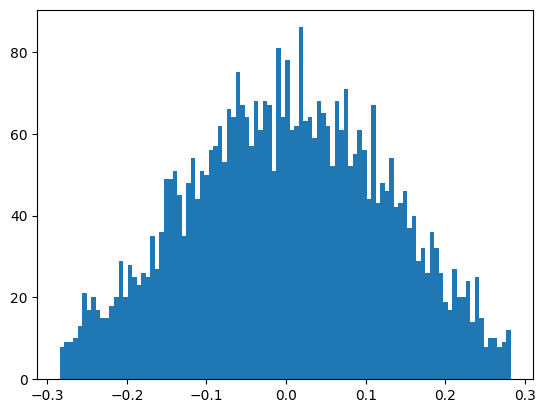

In [12]:
import matplotlib.pyplot as plt
plt.hist(params['params']['Dense_0']['kernel'].flatten(), bins=100)
plt.show()